# Compare Pressure and Volume Results
### -- Info

This notebook can be used to compare the results obtained from a FEBio simulation and the ideal volume curve

Results from simulation must be in a pickle dataframe with "volume" and "timestep" columns. The "PAQ-GammaStudy.ipynb" can be used to compute this dataframe.
PV-curve must be in a pickle dataframe. The "smooth_data.ipynb" can be used to comput this dataframe.

## Notes:
-- This space is reserved for notes before printing final results. Change text accordingly --


In [1]:
import numpy as np
import pandas as pd

## Set Initial parameters

Set path to files and what files to analyze -> these are the inputs, we can change these based on what data we want to analyze

In [2]:
# result picke file
PV_RESULT_FILES = [
        "D:\\Igor\\Research_USF\\University of South Florida\\Mao, Wenbin - Igor\\Febio-Models\\Active-Models\\PAQ\\Pressure-Volume-1\\forest_reg\\1cycle\\pickles\\final-data\\final-df.pickle",
        ]

# sample pv-curve dataframe
PV_SAMPEL_FILE = "D:\\Igor\\GitHub\\FEBio-Python\\notebooks\\smoothData\\out\\pv_curve.pickle"

cycles = 1 # or list with direct refs as: [1, 1, 2]
cycle_time = 0.8
refs = "param_val" # or list with direct refs as: ["Forest_reg", "Elastic_reg", "Forest_reg_2_cycles"]

## Adjust DFs
Make adjustments on results dataframes to match pressure values (interpolate values based on timestep)

Also set proper sample dataframes with the correct data based on cycles

Read pickles

In [4]:
pv_r_dfs = [pd.read_pickle(f) for f in PV_RESULT_FILES]
pv_s_df = pd.read_pickle(PV_SAMPEL_FILE)

In [ ]:
if type(refs) == str() and len(PV_RESULT_FILES) == 1:
    refs = pv_r_dfs[0][refs].copy()
    pv_r_dfs = pv_r_dfs[0].groupby(refs).values

In [5]:
# define an interpolation wrapper, will be used to fix the number of datapoints
from scipy.interpolate import interp1d
def interp_wrap(x,y,x_new, kind='linear'):
    f = interp1d(x, y, kind=kind)
    y_new = f(x_new)
    return y_new.reshape((y_new.shape[0], 1))

In [6]:
# this function adjust dataframe based on the max_timestep and interpolates values based on sample df
def adjust_df(df, maxTimestep, dfSample):
    df["timestep"].loc[df["timestep"] > maxTimestep] = maxTimestep
    df["pressure"] = interp_wrap(dfSample["timestep"], dfSample["pressure"], df["timestep"])
    return df

In [7]:
# this function creates a sample dataframe based on the number of cycles and reference df
def make_df_ncycles_sample(df,n=2):
    new_df = pd.DataFrame([], columns=["timestep", "pressure"])
    n_timesteps = [df["timestep"] + df["timestep"].max() * (n_i) for n_i in range(n)]
    # new_df["timestep"] = np.hstack([df["timestep"], df["timestep"] + df["timestep"].max()] ).reshape((df["timestep"].shape[0]*n,))
    new_df["timestep"] = np.hstack(n_timesteps).reshape((df["timestep"].shape[0]*n,))
    new_df["pressure"] = np.hstack([df["pressure"], df["pressure"]]).reshape((df["pressure"].shape[0]*n,))
    new_df["volume"]   = np.hstack([df["volume"], df["volume"]]).reshape((df["volume"].shape[0]*n,))
    return new_df

Start by creating necessary sample dataframes with the correct number of cycles. To save on memory, we will first create a dictionary to hold each dataframe and then set a list with references to the dictionary. This way we do not need to replicate unecessary data. 

In [8]:
# Create the dictionary map
pvs_map = {1: pv_s_df}
for nc in cycles:
    if nc not in pvs_map:
        pvs_map[nc] = make_df_ncycles_sample(pv_s_df, nc)

# Set a list with references to the dictionary
pv_s_dfs = []
for nc in cycles:
    pv_s_dfs.append(pvs_map[nc])

Now we will be doing the necessary adjustments to each result dataframe. They will be inplace adjustments

In [9]:
for n_cycles, r_df, s_df in zip(cycles, pv_r_dfs, pv_s_dfs):
    r_df = adjust_df(r_df, cycle_time * n_cycles, s_df)

## Plot Results
Let's see how good our data was

Plot ideal volume vs actual volume

In [10]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

def plot_vt(s_df, r_df, ref_name=""):
    fig, ax = plt.subplots()

    ax.scatter(s_df["timestep"], s_df["volume"])
    ax.scatter(r_df["timestep"], r_df["volume"])

    ax.grid(color='k', linestyle='--', linewidth=0.25)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("Volume [ml]")
    ax.set_title("Ideal volume vs Actual volume - {}".format(ref_name))
    ax.legend(["Ideal", "Actual"])

    plt.show()

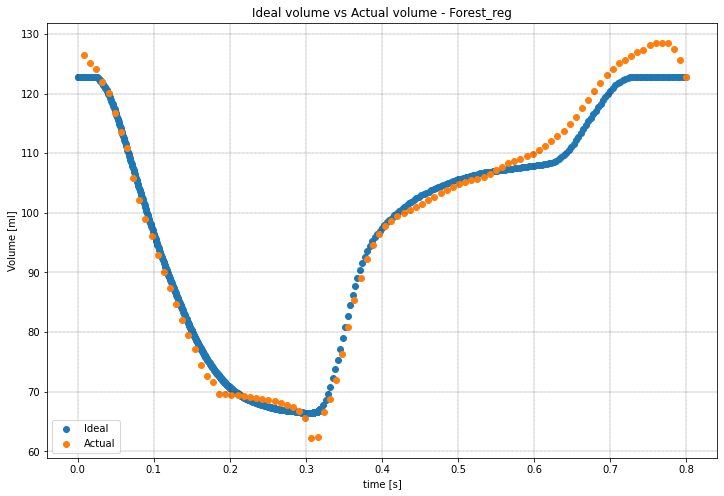

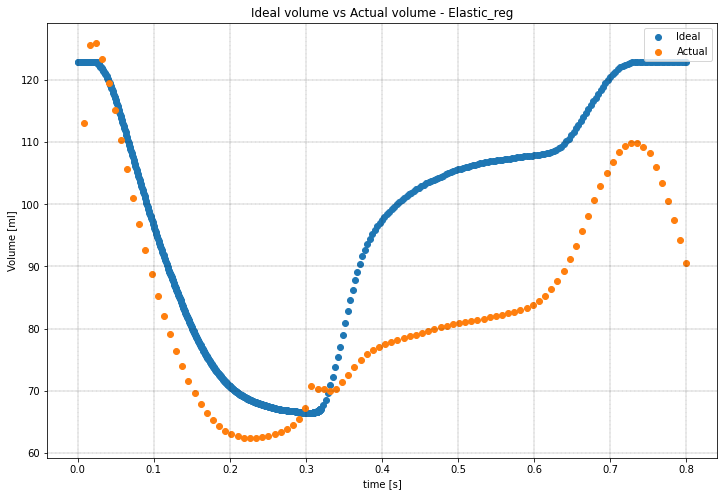

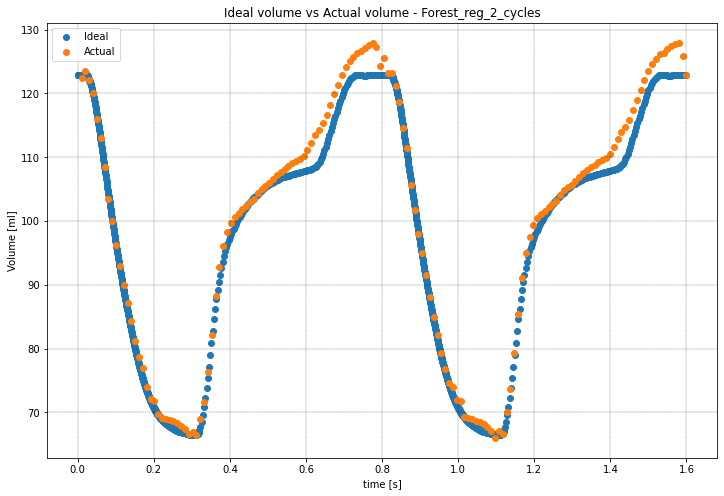

In [11]:
for r_df, s_df, ref in zip(pv_r_dfs, pv_s_dfs, refs):
    plot_vt(s_df, r_df, ref)

Plot the "match" curve

In [12]:
# interpolate volume values to account to fixed timestep size
s_v_interps = []
for s_df, r_df in zip(pv_s_dfs, pv_r_dfs):
    s_v_interps.append(interp_wrap(s_df["timestep"], s_df["volume"], r_df["timestep"]))

In [13]:
def plot_match_curve(sv_interp, r_df, ref_name=""):
    fig, ax = plt.subplots()

    min_v, max_v = sv_interp.min() *0.95, sv_interp.max() * 1.05

    plt.xlim(min_v, max_v)
    plt.ylim(min_v, max_v)

    ax.plot([min_v,max_v] , [min_v,max_v], c="r")
    ax.scatter(sv_interp, r_df["volume"])

    ax.grid(color='k', linestyle='--', linewidth=0.25)
    ax.set_xlabel("Ideal volume [ml]")
    ax.set_ylabel("Actual volume [ml]")
    ax.set_title("Ideal Curve - {}".format(ref_name))
    ax.legend(["Match", "Values"])

    plt.show()

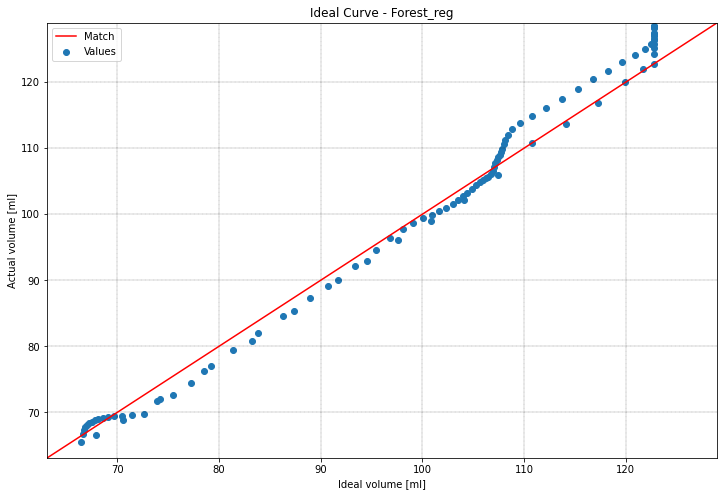

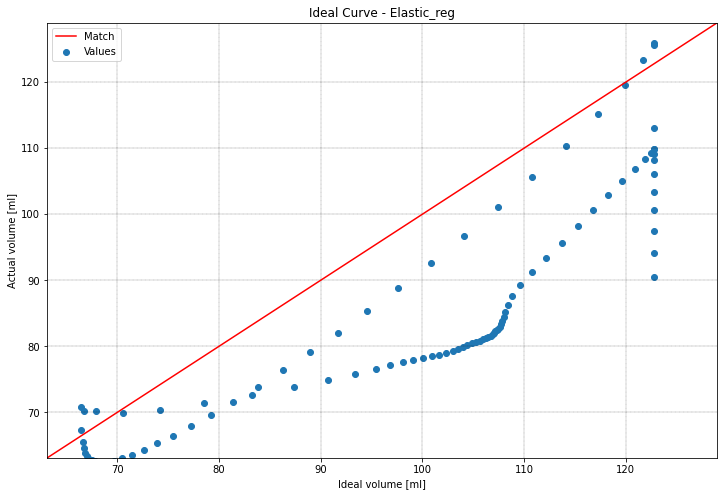

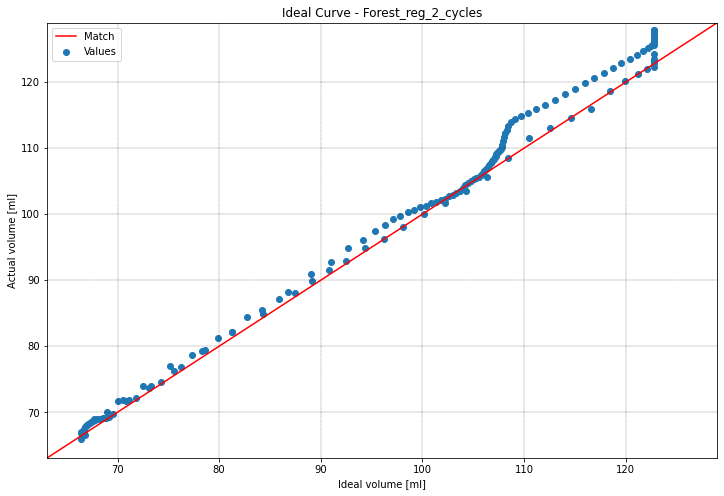

In [14]:
for sv_interp, r_df, ref in zip(s_v_interps, pv_r_dfs, refs):
    plot_match_curve(sv_interp,r_df, ref)

Plot the relative error

In [15]:
def calc_rel_err(df, sv_interp):
    r_vols = df["volume"].values.reshape((df["volume"].shape[0], 1))
    err = ((r_vols - sv_interp) / r_vols ) * 100
    return err

In [16]:
errs = []
for r_df, sv_interp in zip(pv_r_dfs, s_v_interps):
    errs.append(calc_rel_err(r_df, sv_interp))

In [17]:
def plot_rel_error(r_df, err, ref_name=""):
    fig, ax = plt.subplots()

    min_t, max_t = r_df["timestep"].min() *0.95, r_df["timestep"].max() * 1.05
    plt.xlim(min_t, max_t)

    ax.plot([min_t,max_t] , [0,0], c="r")
    ax.scatter(r_df["timestep"], err)

    ax.grid(color='k', linestyle='--', linewidth=0.25)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Error [%]")
    ax.set_title("Relative error - {}".format(ref_name))
    ax.legend(["Error"])

    plt.show()

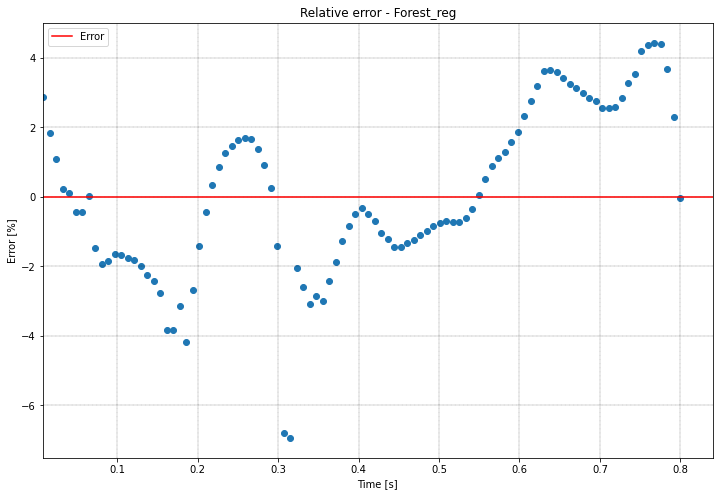

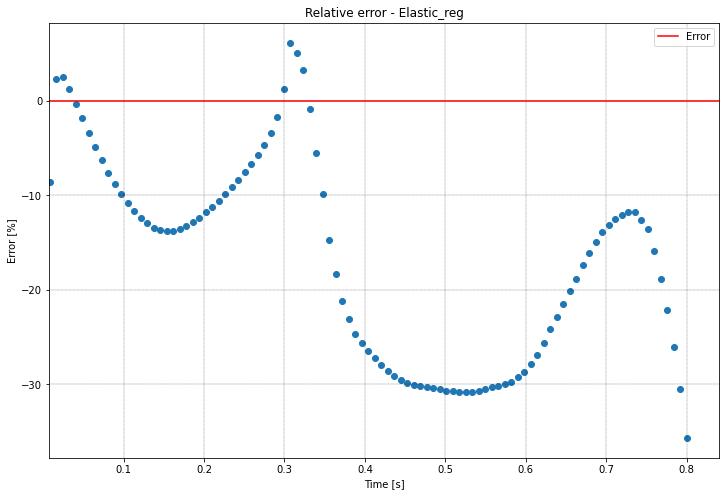

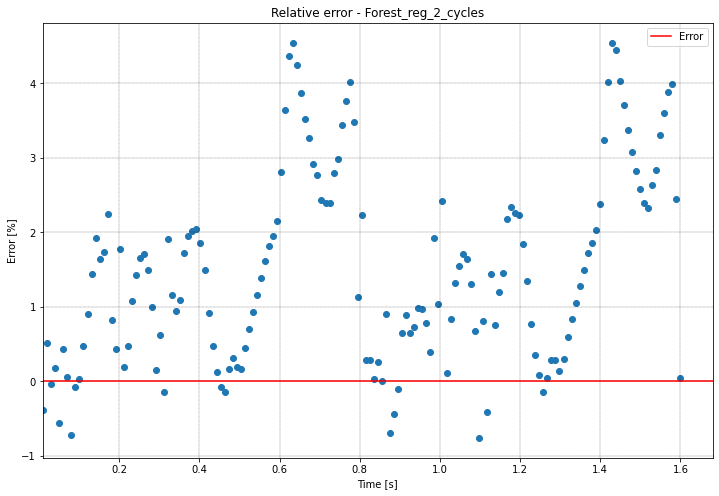

In [18]:
for r_df, err, ref in zip(pv_r_dfs, errs, refs):
    plot_rel_error(r_df, err, ref)

Just to double check, lets plot the pressure curves

In [19]:
def plot_pt(r_df, s_df, ref_name):
    fig, ax = plt.subplots()

    ax.scatter(s_df["timestep"], s_df["pressure"])
    ax.scatter(r_df["timestep"], r_df["pressure"])

    ax.grid(color='k', linestyle='--', linewidth=0.25)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("Pressure [ml]")
    ax.set_title("Pressure vs Time - {}".format(ref_name))
    ax.legend(["Ideal", "Actual"])

    plt.show()

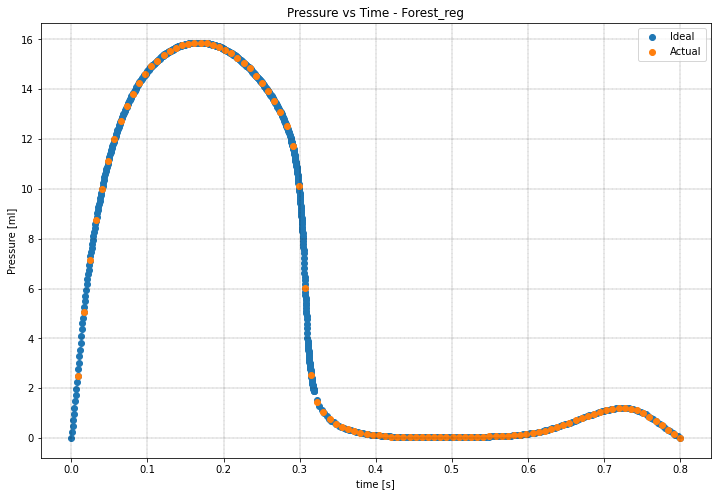

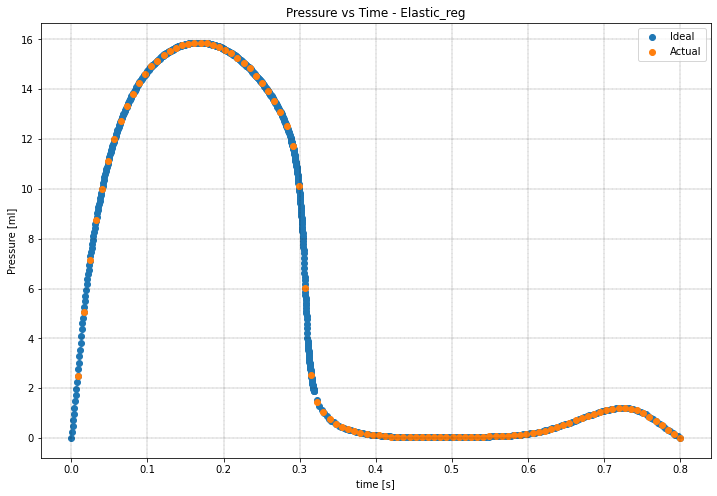

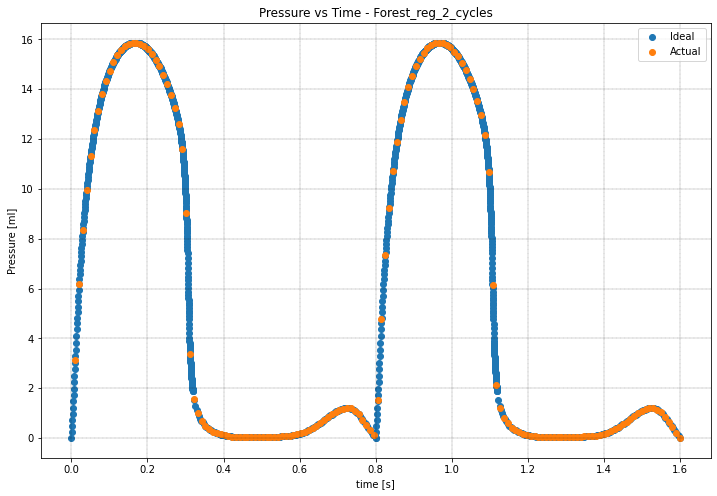

In [20]:
for r_df, s_df, ref in zip(pv_r_dfs, pv_s_dfs, refs):
    plot_pt(r_df, s_df, ref)

Plot pressure vs volume

In [21]:
def plot_pv(r_df, s_df, ref_name):
    fig, ax = plt.subplots()

    ax.scatter(s_df["volume"], s_df["pressure"])
    ax.scatter(r_df["volume"], r_df["pressure"])

    ax.grid(color='k', linestyle='--', linewidth=0.25)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("Pressure [ml]")
    ax.set_title("Pressure vs Time - {}".format(ref_name))
    ax.legend(["Ideal", "Actual"])

    plt.show()

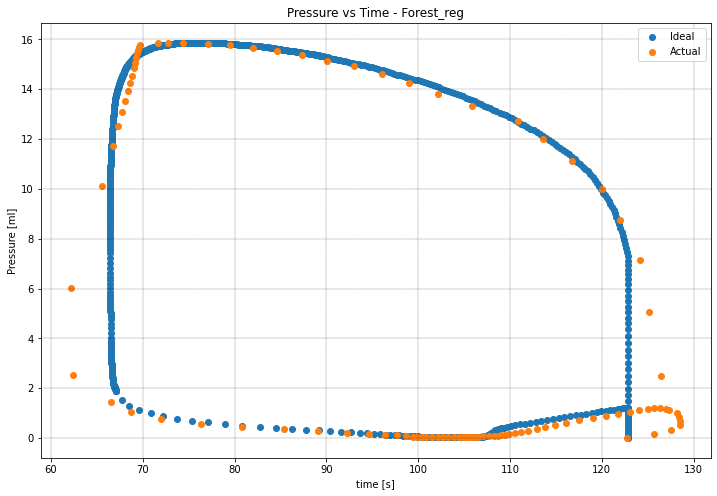

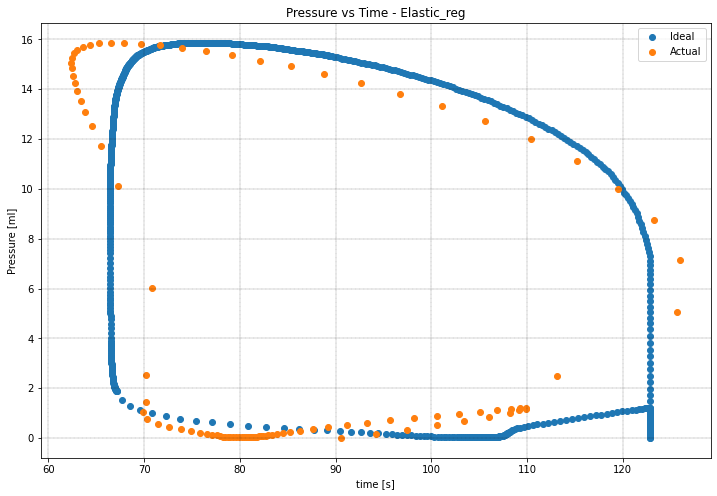

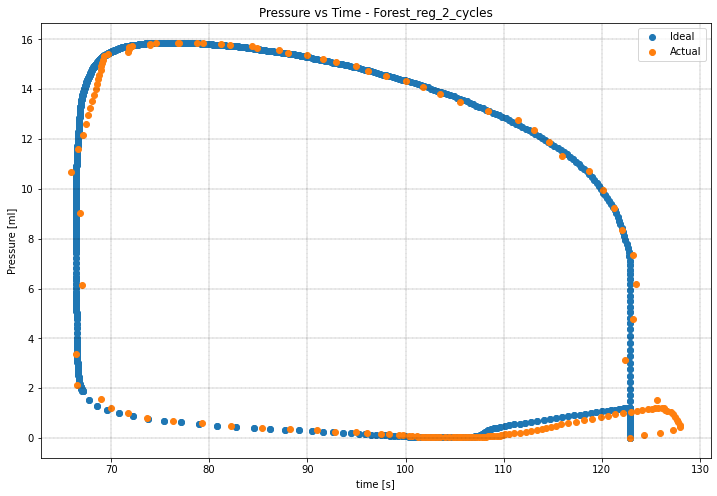

In [22]:
for r_df, s_df, ref in zip(pv_r_dfs, pv_s_dfs, refs):
    plot_pv(r_df, s_df, ref)